# Hands-on session: Analysis of Higgs data

In [1]:
%reload_ext custom_magics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from custom_functions import *

In [3]:
num_workers = 5
spark = %sc $num_workers

from pyspark.sql import SparkSession

spark_session = SparkSession(spark)

# check if spark is there
spark

Exception in thread Thread-3:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 126, in run
    self.onrecv(msg)
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 143, in onrecv
    sendToFrontEnd({
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 223, in sendToFrontEnd
    monitor.send(msg)
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 57, in send
    self.comm.send(msg)
AttributeError: 'ScalaMonitor' object has no attribute 'comm'


<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-marchisi01>

## Prepare the input data

In [27]:
# inputFile = "file:///home/jovyan/Higgs100k.parquet"
inputFile = "file:///home/jovyan/Higgs1M.parquet"
# inputFile = "file:///home/jovyan/Higgs10M.parquet"

%time df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)


CPU times: user 2.67 ms, sys: 1.72 ms, total: 4.39 ms
Wall time: 216 ms


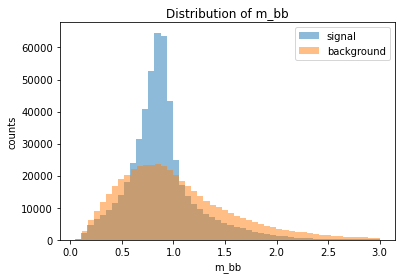

In [28]:
plotSignalvsBg(df, "m_bb")

In [29]:
total_events = df.count()
print("There are " + str(total_events) + " events")

There are 999999 events


## Feature engineering

### QUESTION 1: 

- Is the dataset unbalanced? 
- Do we need undersampling? 
- Do we need special preprocessing?

In [30]:
# Check the distribution of signal vs background
label_counts = df.groupBy("label").count().toPandas()
print("Label distribution:")
label_counts

Label distribution:


,label,count
0,0.0,470326
1,1.0,529673


In [31]:
# Calculate the ratio
signal_count = label_counts[label_counts["label"] == 1]["count"].values[0]
background_count = label_counts[label_counts["label"] == 0]["count"].values[0]
ratio = signal_count / background_count

print(f"Signal events: {signal_count}")
print(f"Background events: {background_count}")
print(f"Signal/Background ratio: {ratio:.3f}")

Signal events: 529673
Background events: 470326
Signal/Background ratio: 1.126


### Answer:

| dataset   | # signal | # bkg   | ratio |
|-----------|----------|---------|-------|
| Higgs100k | 52833    | 47166   | 1.120 |
| Higgs1M   | 529673   | 470326  | 1.126 |
| Higgs10M  | 5299505  | 4700495 | 1.127 |

No, the dataset (even in its biggest version) is fairly balanced, so no undersampling is needed.

Features are not scaled between -1 and 1, so for those models that perform better with [-1,1] distributed features one may decide to perform such preprocessing.

### QUESTION 2: 

- Split the dataset into 5 roughly equal parts with random events

In [32]:
# Use randomSplit to divide the data into 5 equal parts
splits = df.randomSplit([0.2, 0.2, 0.2, 0.2, 0.2], seed=42)

# Verify the splits
for i, split in enumerate(splits):
    print(f"Part {i + 1}: {split.count()} events")

Part 1: 200197 events
Part 2: 200163 events
Part 3: 200342 events
Part 4: 198855 events
Part 5: 200442 events


### QUESTION 3: 
- split the dataset for training and test

In [39]:
# Split into 80% training and 20% test
train, test = df.randomSplit([0.8, 0.2], seed=42)

print(f"Events for training: {train.count()}")
print(f"Events for test: {test.count()}")

Events for training: 799557
Events for test: 200442


### QUESTION 4:

- Create the input feature vector for MLLib
- Documentation on how to do data preprocessing in Spark: https://spark.apache.org/docs/latest/ml-features.html

In [40]:
from pyspark.ml.feature import VectorAssembler

# Get all feature columns (all columns except 'label')
feature_cols = train.columns.copy()
feature_cols.remove("label")

print(f"Features: {feature_cols}")
print(f"Number of features: {len(feature_cols)}")

Features: ['lepton_pT', 'lepton_eta', 'lepton_phi', 'missing_energy_magnitude', 'missing_energy_phi', 'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_b-tag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_b-tag', 'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_b-tag', 'jet4_pt', 'je4_eta', 'jet4_phi', 'jet4_b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
Number of features: 28


In [41]:
# VectorAssembler combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform both train and test datasets
train = assembler.transform(train)
test = assembler.transform(test)

# Verify the transformation
display(train)

DataFrame[label: double, lepton_pT: double, lepton_eta: double, lepton_phi: double, missing_energy_magnitude: double, missing_energy_phi: double, jet1_pt: double, jet1_eta: double, jet1_phi: double, jet1_b-tag: double, jet2_pt: double, jet2_eta: double, jet2_phi: double, jet2_b-tag: double, jet3_pt: double, jet3_eta: double, jet3_phi: double, jet3_b-tag: double, jet4_pt: double, je4_eta: double, jet4_phi: double, jet4_b-tag: double, m_jj: double, m_jjj: double, m_lv: double, m_jlv: double, m_bb: double, m_wbb: double, m_wwbb: double, features: vector]

## ML with pyspark

- Try to solve the signal vs background classification problem using a **new model of your choice** (obviously, not GBT or MCP)
- Documentation at: https://spark.apache.org/docs/3.2.1/ml-classification-regression.html

Fit the model on the **training dataset**: (dataframe train)

In [42]:
# Using Random Forest Classifier
from pyspark.ml.classification import RandomForestClassifier

# Create the Random Forest model
rf = RandomForestClassifier(
    labelCol="label",
    featuresCol="features",
    numTrees=50,  # Number of trees in the forest
    maxDepth=15,  # Maximum depth of trees
    seed=42,
)


In [43]:
# Train the model
%time rf_model = rf.fit(train)

CPU times: user 48.7 ms, sys: 27.3 ms, total: 76 ms
Wall time: 5min 30s


### QUESTION 5: 

- Compute the accuracy/AUC/relevant metrics on the test dataset

In [44]:
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator,
    MulticlassClassificationEvaluator,
)

# Make predictions on test data
result = rf_model.transform(test)
printMetrics(auc_evaluator, result)

AUC: 0.803
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|80171|
|  0.0|       1.0|28929|
|  1.0|       0.0|26330|
|  0.0|       0.0|65012|
+-----+----------+-----+

n precision: 0.735
n recall: 0.753
n accuracy: 0.724
n F1 score: 0.744


In [45]:
# AUC (Area Under ROC Curve)
auc_evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    metricName="areaUnderROC",
)
auc = auc_evaluator.evaluate(result)


In [46]:
# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy",
)
accuracy = accuracy_evaluator.evaluate(result)

In [47]:
# F1 Score
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1",
)
f1 = f1_evaluator.evaluate(result)

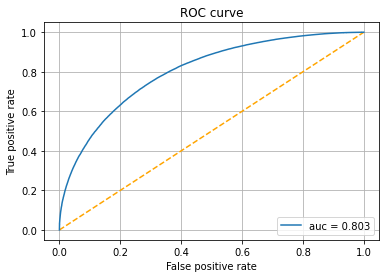

In [48]:
# Draw ROC curve
drawROC(result)

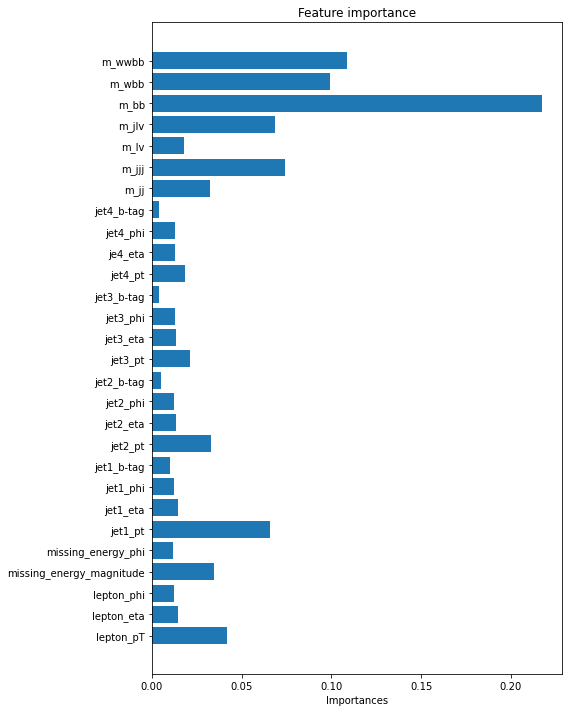

In [49]:
# Plot feature importance
drawFeatures(feature_cols, rf_model)

### QUESTION 6: 

- Check that you are neither underfitting nor overfitting

In [50]:
# Compute metrics on TRAINING data
result_train = rf_model.transform(train)

In [51]:
# AUC on training
train_auc = auc_evaluator.evaluate(result_train)
print(f"Training set AUC = {train_auc:.4f}")
print(f"Test set AUC = {auc:.4f}")

Training set AUC = 0.8748
Test set AUC = 0.8027


In [52]:
# Accuracy on training
train_accuracy = accuracy_evaluator.evaluate(result_train)
print(f"\nTraining set Accuracy = {train_accuracy:.4f}")
print(f"Test set Accuracy = {accuracy:.4f}")


Training set Accuracy = 0.7930
Test set Accuracy = 0.7243


In [54]:
# Calculate the gap
auc_gap = train_auc - auc
accuracy_gap = train_accuracy - accuracy

print(f"\n--- Overfitting Analysis ---")
print(f"AUC gap (train - test): {auc_gap:.4f}")
print(f"Accuracy gap (train - test): {accuracy_gap:.4f}")


--- Overfitting Analysis ---
AUC gap (train - test): 0.0720
Accuracy gap (train - test): 0.0687


The model shows a little overfitting, as highlithed by the non-zero but sub-10% AUC and accuracy gaps between training and test datasets.

In [55]:
# When you're done, stop spark
spark.stop()

### Final results

Pick any two models (can be any from pyspark MLLib, Keras + BigDL sequential) and  (you can use results from previous days):
- Compare them in terms of absolute performances. Discuss accuracy, ROC, AUC, feature importance, feature distributions. Which of these metrics do you deem more critical?
- Compare how they scale in terms of performances and training time when you change the number of executors (from 1 to 5)
- Discuss the results.  
- You can also collect results in external documents (google documents, pdf, whatever) and link them here